In [0]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
import seaborn as sns

# import matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()


In [4]:
from google.colab import files
uploaded = files.upload()


Saving testdata_v3.csv to testdata_v3.csv


# data visualization:

In [0]:
# from pandas.tools.plotting import parallel_coordinates
import matplotlib.pyplot as plt

column_names = ["g_x", "g_y", "g_z", "a_x", "a_y", "a_z", "target"]

df = pd.read_csv("testdata.csv", names= column_names)
# print(df)
target = df.target
count = 0
for i, data in enumerate(target):
  if count<10:
    target[i] = count
    
  else:
    count = 0
    target[i] = count
  count += 1
# print(target)

plt.plot(target, df.filter(items = ['a_x',0:9]))
plt

SyntaxError: ignored

# neural network 

In [16]:
# train_df, test_df = train_test_split(df, test_size =0.2)
column_names = ["g_x", "g_y", "g_z", "a_x", "a_y", "a_z", "target"]
df = pd.read_csv("testdata_final.csv", names = column_names)
print(df)

# for i,row in df.iterrows():
#   if (row[6] != 0):
#     row[7] = 1
#   else:
#     row[7] = 0
# print(df)
# print(df)
target = df.target

train_labels = target[:690]
test_labels = target[690:]
# print(train_label.shape)


df.drop(['target', 'g_y','g_z','g_x'],axis = 1 , inplace = True)
train_df = df[:690]
test_df = df[690:]
# print(train_df.shape)


FileNotFoundError: ignored

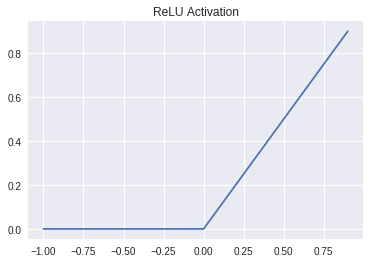

In [0]:
# ReLU Activation
def relu(x):
    return np.maximum(x, 0)

x = np.arange(-1, 1, .1)
plt.plot(x, relu(x))
plt.title("ReLU Activation")
plt.show()

# classification:

In [0]:
# Let's first make sure the shape and type of our data is correct.
# Convert data to float32 datatype and labels to int64 datatype.
train_data = np.array(train_df)
train_label = np.array(train_label)

test_data = np.array(test_df)
test_label = np.array(test_label)

train_data = tf.cast(train_data, tf.float32)
train_labels = tf.cast(train_label, tf.int64)
test_data = tf.cast(test_data, tf.float32)
test_labels = tf.cast(test_label, tf.int64)

# When working with images, TensorFlow needs them to be shape [H, W, C], but 
# our data is just [H, W] right now since its black and white. Let's add a extra channel axis.
# train_data = train_data[..., tf.newaxis]
# test_data = test_data[..., tf.newaxis]

# Now were ready to create Tensorflow Datasets!
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Finally, let's shuffle our training data and batch it so its more efficient.
train_dataset = train_dataset.shuffle(1000).batch(10)
test_dataset = test_dataset.batch(10)


print(train_dataset)

<BatchDataset shapes: ((?, 3), (?,)), types: (tf.float32, tf.int64)>


In [0]:
# We create a model that is a subclass of tf.keras.Model. This means that it inherits from keras but allows us to define new operations as well.
class Model(tf.keras.Model):
  # Init function is called when model is first built.
  def __init__(self):
    # Using super calls the init function for this classes parent.
    super(Model, self).__init__()
    # Define weight tensor, should be 10 values for 10 output classes.
    self.W = tf.Variable(np.zeros(shape=[3, 10], dtype=np.float32), name='weight')
    # Similarly define a bias for each neuron.
    self.B = tf.Variable(np.zeros(10, dtype=np.float32), name='bias')
    # Need to be able to squish the inputs down to a flat tensor for weight multiplication.
    self.flatten = tf.keras.layers.Flatten()
  
  # Call function applies the weights and bias of the model to the passed inputs.
  def call(self, inputs):
    # Need inputs to be flat for dense layer.
    flat_inputs = self.flatten(inputs)
    # Apply matrix multiplication with weights and add bias to results.
    return tf.matmul(flat_inputs, self.W) + self.B

In [0]:
# Pass in the model being trained, the inputs, and the correct labels.
def loss(model, inputs, targets):
  # Get the guess of the model.
  guess = model(inputs)
  
  # Before subtracting from guess, must make labels "one-hot", instead of label 3, we want [0, 0, 0, 1, 0, 0, ...]
  targets = tf.one_hot(targets, depth=10)
  # Also cast to float for proper subtraction.
  targets = tf.cast(targets, tf.float32)
  # Find distance between guess and correct answer.
  error = guess - targets
  # Average the error across each label and square to avoid negatives.
  return tf.reduce_mean(tf.square(error))

In [0]:
# Pass model, inputs, and correct labels.
def grad(model, inputs, targets):
  # Keep track of gradients within this scope.
  with tf.GradientTape() as tape:
    # Compute the loss for the current input sample.
    loss_value = loss(model, inputs, targets)
    # Now find gradient of loss with respect to our model's variables.
    grads = tape.gradient(loss_value, [model.W, model.B])
  return grads

# Use a simple SGD optimizer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

In [0]:
# Create an instance of our model.
model = Model()
losses = []

# Go through the training data 5 times.
for epoch in range(3):
  # Iterate through samples of training data.
  for i, (data, label) in enumerate(train_dataset):
    # Compute loss and gradients for current batch.
    grads = grad(model, data, label)
    # Apply computed gradients using SGD to update our variables.
    optimizer.apply_gradients(zip(grads, [model.W, model.B]), global_step=tf.train.get_or_create_global_step())
    
    # Print the loss every 200 batches
    if i % 200 == 0:
      L = loss(model, data, label)
      print("Loss at step %d: %.3f" % (i, L))
      losses.append(L)

Loss at step 0: 40864508.000
Loss at step 0: nan
Loss at step 0: nan


# regression

In [28]:

NN_model = Sequential()

# train_data = tf.cast(train_df, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
# test_data = tf.cast(test_df, tf.float32)
test_labels = tf.cast(test_labels, tf.int64)

train_data = np.asarray(train_df)
train_labels = np.asarray(train_labels)
train_data = train_data.astype(np.float)
train_labels = train_labels.astype(np.float)

test_data = np.asarray(test_df)
test_labels = np.asarray(test_labels)
test_data = test_data.astype(np.float)
test_labels = test_labels.astype(np.float)

# The Input Layer :
# print(train_data.shape[1])
input_dim= int((train_data.shape[1]))
print(input_dim)

verbose, epochs, batch_size = 0, 15, 10

# model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, verbose=verbose)
# model = Sequential()
# model.add(tf.keras.layers.LSTM(10, input_shape=4))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dense(2, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, verbose=verbose)

# NN_model.add(Dense(128, kernel_initializer='normal',input_dim = input_dim, activation='relu'))

# # The Hidden Layers :
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# # The Output Layer :
# NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
# NN_model.compile (loss='mean_absolute_error', optimizer=tf.train.AdamOptimizer(), metrics=['mean_absolute_error'])
NN_model.summary()


4


AttributeError: ignored

In [0]:
checkpoint_name = 'Weights-best.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [0]:

NN_model.fit(train_data, train_labels, epochs=200, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


In [0]:
# Load wights file of the best model :
# print(weights)


wights_file = 'Weights-best.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer=tf.train.AdamOptimizer(), metrics=['mean_absolute_error'])
  
#   sess.run(tf.global_variables_initializer())


In [0]:

predictions = NN_model.predict(test_data)
# print(predictions)
count = 0
for i,prediction in enumerate(predictions):
#   print(prediction[0])
#   print(test_lab)
  if abs(prediction[0] - test_labels[i])<0.5:
    count += 1

accuracy = count/len(test_label)
print("accuracy: %f%%" %(accuracy*100))
# score = NN_model.evaluate(test_data, test_label, verbose=0)
# print(score)



accuracy: 70.503597%


# Random Forest Regression:



data training

In [0]:
# train_df, test_df = train_test_split(df, test_size =0.2)
column_names = ["g_x", "g_y", "g_z", "a_x", "a_y", "a_z", "target"]

df = pd.read_csv("testdata_final (2).csv", names = column_names)
# df = df.values
# for i,data in enumerate (df):
  
# print(df.values)
target = df.target

# count = 0
# for i, data in enumerate(target):
#   if count<10:
#     target[i] = count
    
#   else:
#     count = 0
#     target[i] = count
#   count += 1

train_label = target[:690]
test_label = target[690:]
# print(train_label)
# print(test_label)
df.drop(['target', 'g_y','g_z','a_y','a_z', 'g_x'],axis = 1 , inplace = True)
train_df = df[:690]
test_df = df[690:]

# print(train_df)

In [0]:
# train_X, val_X, train_y, val_y = train_test_split(train_df, train_label, test_size = 0.25, random_state = 14)

model = RandomForestRegressor()
model.fit(train_df,train_label)

# Get the mean absolute error on the validation data
predicted_prices = model.predict(test_df)
MAE = mean_absolute_error(test_label , predicted_prices)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  0.45650980392156865


data testing

In [0]:
prediction = model.predict(test_df)


labels = np.array(test_label)
# print(prediction)
correct = 0
for i, data in enumerate (prediction):
  if data == labels[i]:
#     print(data)
#     print("correct")
    correct += 1
#   else:
#     print(data)
#     print("incorrect")
accuracy = correct / len(test_label)
print("accuracy: %f% %" %(accuracy*100))

accuracy: 24.705882%


False
True


# testing:

In [6]:
column_names = ["g_x", "g_y", "g_z", "a_x", "a_y", "a_z", "step"]
df = pd.read_csv("testdata_v3.csv", names = column_names)
df['target'] = 0

for i,row in df.iterrows():
  if (row[6] != 0):
    row[7] = 1
  else:
    row[7] = 0
print(df)
target = df.target

train_labels = target[:690]
test_labels = target[690:]

df.drop(['target', 'g_y','g_z','g_x'],axis = 1 , inplace = True)
train_df = df[:690]
test_df = df[690:]


       g_x    g_y    g_z    a_x    a_y    a_z  step  target
0    -1065    341   -547   4872   -172  16960     1       1
1    -1264    116   -330   5020    176  17032     2       1
2     -826     -1  -1048   4812    440  16672     3       1
3     2573    362  -3953   4456   3256  17928     4       1
4     2589  -3712 -10000    652  14764  17908     5       1
5    -2199    131   3280  -1512   8068  13856     6       1
6    -2109   1786  18115  -2000 -32768  17008     7       1
7     2943  -1237    735   9356  -9796  14024     8       1
8    -2333   2480   -627   5244   2744  17188     9       1
9    -1028   -212  -2210   4048   3364  18204    10       1
10    -924    251   -337 -10180   8372   9052     0       0
11    -928    242   -320 -10264   8272   9020     0       0
12    -930    252   -318 -10204   8248   8812     0       0
13    -917      0   -300 -10148   8168   8972     0       0
14    -914    509   -338 -10212   8300   8788     0       0
15    -921    249   -301 -10292   7960  

In [7]:
train_data = np.array(train_df)
train_labels = np.array(train_labels)

test_data = np.array(test_df)
test_labels = np.array(test_labels)

train_data = tf.cast(train_data, tf.float32)
train_labels = tf.cast(train_labels, tf.int64)
test_data = tf.cast(test_data, tf.float32)
test_labels = tf.cast(test_labels, tf.int64)
# print(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))


# Finally, let's shuffle our training data and batch it so its more efficient.
train_dataset = train_dataset.batch(10)
test_dataset = test_dataset.batch(10)
print(train_dataset)

<DatasetV1Adapter shapes: ((?, 4), (?,)), types: (tf.float32, tf.int64)>


In [0]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.flatten = tf.keras.layers.Flatten()
#     self.dense0 = tf.keras.layers.Dense(128, activation='relu')
    self.dense1 = tf.keras.layers.CuDNNLSTM(units=4, stateful=True)
#     self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu)
    self.dense3 = tf.keras.layers.Dense(2)
    
# lstm_model.add(tf.keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, stateful=True))
# lstm_model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
  def call(self, inputs):
    x = self.flatten(inputs)
#     x = self.dense0(x)
    x = self.dense1(x)
#     x = self.dense2(x)
    x = self.dense3(x)
    return x
def loss(model, inputs, targets):
  guess = model(inputs)
  return tf.losses.sparse_softmax_cross_entropy(targets, guess)
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    L = loss(model, inputs, targets)
    grads = tape.gradient(L, model.trainable_variables)
  return grads


In [0]:
def test_model(model, dataset):
  correct = 0
  total = 0
  for i, (data, label) in enumerate (dataset):
    guesses = model(data)
    best_guesses = tf.argmax(guesses, axis = -1)
    correct += tf.count_nonzero(tf.equal(best_guesses, label))
    total += data.shape[0]
    return (correct/total).numpy()

In [0]:
def train_model(model, dataset, optimizer):
  losses = []
  for epoch in range(5):
    for i, (data, label) in enumerate(dataset):
      grads = grad(model,data, label)
      optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step=tf.train.get_or_create_global_step())
      if i %200 == 0:
        L = loss(model, data, label)
        print("loss at step %d : %.3f " %(i,L))
        losses.append(L)
  return losses

In [22]:
model = Model()

optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
losses = train_model(model, train_dataset, optimizer)
test_acc = test_model(model, test_dataset)
print("accuracy: %f% %" %(test_acc*100))

ValueError: ignored